In [1]:
from rl755.data.car_racing import encoded_rollouts
from rl755.data.car_racing import processing
from rl755.models.car_racing import transformer
from rl755.models.car_racing import saved_models
from rl755.models.car_racing import unet

import importlib
import functools
import tensorflow as tf
import matplotlib.pyplot as plt


In [5]:
encoded_rollouts.TFRECORDS_PATTERN = (
    "/media/hastings/4083E9FE44A0B1BD/comp_755_data/"
    "encoded_rollouts/{split}/encoded_rollouts*"
)

In [6]:
vae = saved_models.raw_rollout_vae_32ld("/media/hastings/4083E9FE44A0B1BD/comp_755_data/test_vae_train/model.hdf5")

In [7]:
FLAGS = lambda: None
FLAGS.sequence_length = 128
FLAGS.batch_size=128

In [48]:
import numpy as np
from noise import pnoise1
def makeNoise(l):
    start = np.random.random() * 10000
    out = []
    for _ in range(l):
        a = pnoise1(_ / 140 + start, 5)
        out.append(a)
    return np.array(out)

def mask():
    m = makeNoise(FLAGS.sequence_length) > 0
    m = m.reshape (FLAGS.sequence_length, 1)
    m = np.repeat(m, 37, 1)
    m[:, -4:] = 1
    return m
mask().shape
mymask = mask()

In [56]:


def to_ar_inputs_and_targets(x, sequence_length, latent_size=32, action_size=4):
    """Given a slice of a rollout, convert it to inputs and targets for autoregressive modelling.

    We do it like this:
        o[i], a[i], r[i-1] => o[i+1], r[i]
    The goal is to predict the next observation and reward given the action taken and the previous states
    and rewards.
    """
    r = tf.expand_dims(x["rewards"], axis=-1)
    a = x["actions"]
    o = x["observations"]
    inputs = tf.concat(
        [o[:], r[:], a[:]],
        axis=-1,
    )
    targets = tf.concat([o[:], r[:]], axis=-1)
    inputs = tf.reshape(inputs, [sequence_length, latent_size + action_size + 1])
    targets = tf.reshape(targets, [sequence_length, latent_size + 1])
    
    return (inputs, mask()), targets


def get_train_ds():
    # We need the `+1` due to how we are processing the sequences.
    ds = encoded_rollouts.random_rollout_slices(slice_size=FLAGS.sequence_length)
    ds = ds.map(
        functools.partial(
            to_ar_inputs_and_targets, sequence_length=FLAGS.sequence_length
        ),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    ds = processing.standard_dataset_prep(
        ds, batch_size=FLAGS.batch_size, repeat=True, shuffle_buffer_size=1000
    )
    return ds

In [57]:
bd = get_train_ds()

In [58]:
aa = bd.as_numpy_iterator().next()

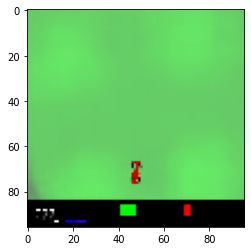

In [61]:
import numpy as np
video = np.array(vae.decode(aa[0][0][99, :, 0:32]))
plt.imshow(video[40])

In [27]:
import cv2
for frame in video:
    cv2.imshow("title", frame)
    cv2.waitKey(1)
    

In [76]:
from tensorflow.keras.layers import Layer

In [2]:
network = unet.sequence_unet()

(None, 128, 37)
(None, 64, 64)
(None, 32, 128)
(None, 16, 256)
(None, 8, 256)
(None, 4, 256)
(None, 2, 256)


In [ ]:
network.compile(loss=tf.keras.losses.mse, optimizer="adam", metrics=[tf.keras.losses.mse])
network.fit(bd, steps_per_epoch=1000, epochs=70)

Train for 1000 steps
Epoch 1/70
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0443 - mean_squared_error: 0.0443
Epoch 2/70
 894/1000 [=========================>....] - ETA: 5s - loss: 0.0381 - mean_squared_error: 0.0381

In [18]:
mask()

NameError: name 'flags' is not defined

In [55]:
aa[2].shape

(128, 128, 33)